[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Beta from formula:  1.1322662929702212
Beta from regression:  1.132266292970221
Expected return:  0.1274535859495579


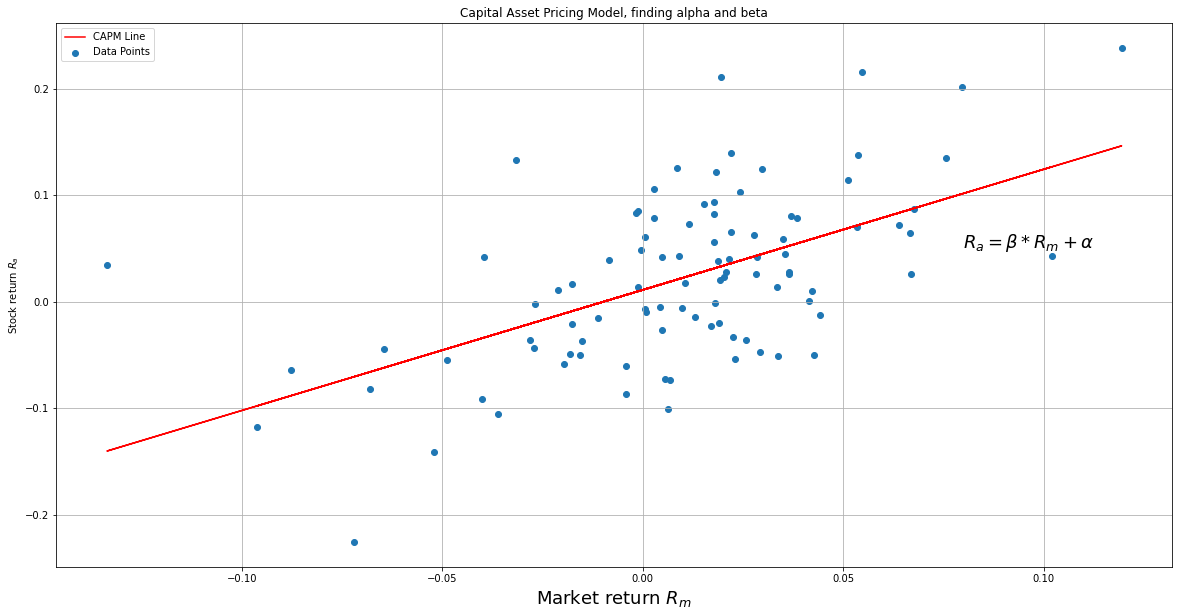

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

#market interest rate
RISK_FREE_RATE = 0.05
#we will consider monthly return and want to calculate the annual return
MONTHS_IN_YEAR = 12

class CAPM:
    
    def __init__(self,stocks,start_date,end_date):
        self.data=None
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date
        
    def download_data(self):
        data = {}
        
        for stock in self.stocks:
            ticker = yf.download(stock,self.start_date,self.end_date)
            data[stock] = ticker['Adj Close']
            
        return pd.DataFrame(data)
    
    def initialize(self):
        stock_data = self.download_data()
        #we want to use monthly returns
        stock_data = stock_data.resample('M').last()
        
        self.data = pd.DataFrame({'s_adjclose': stock_data[self.stocks[0]],
                                  'm_adjclose': stock_data[self.stocks[1]]})
        
        #logarithmic monthly returns
        self.data[['s_returns','m_returns']] = np.log(self.data[['s_adjclose','m_adjclose']]/
                                                     self.data[['s_adjclose','m_adjclose']].shift())
        
        #remove the NaN values
        self.data = self.data[1:]
        
    def calculate_beta(self):
        # covariance matrix: the diagonal items are the variances
        # off diagonals are the covariances
        # the matrix is symmetric: cov[0,1] = cov[1,0] !!!
        covariance_matrix = np.cov(self.data["s_returns"], self.data["m_returns"])
        # calculating beta according to the formula
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
        print("Beta from formula: ", beta)
    
    def regression(self):
        #using linear regression to fit a line to the data
        # [stock_returns, market_returns] - slope is the beta
        beta,alpha = np.polyfit(self.data['m_returns'],self.data['s_returns'],deg=1)
        print("Beta from regression: ",beta)
        # calculate the expected return according to the CAPM formula
        # we are after annual return (this is why multiply by 12)
        expected_return = RISK_FREE_RATE + beta * (self.data['m_returns'].mean()*MONTHS_IN_YEAR
                                                   - RISK_FREE_RATE)
        print("Expected return: ", expected_return)
        self.plot_regression(alpha, beta)
        
    def plot_regression(self, alpha, beta):
        fig,axis = plt.subplots(1,figsize=(20,10))
        axis.scatter(self.data["m_returns"],self.data["s_returns"],label="Data Points")
        axis.plot(self.data["m_returns"], beta * self.data["m_returns"] + alpha,
                  color='red', label="CAPM Line")
        plt.title('Capital Asset Pricing Model, finding alpha and beta')
        plt.xlabel('Market return $R_m$', fontsize=18)
        plt.ylabel('Stock return $R_a$')
        plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha$', fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.show()
        

if __name__=='__main__':
    capm = CAPM(['AMZN', '^GSPC'], '2014-01-01', '2022-01-01')
    capm.initialize()
    capm.calculate_beta()
    capm.regression()